In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from utils import *
from scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_t as mvt 
from tqdm import tqdm

# Introduction to Constrained State-Space Model

Incorporating physicial constrains in our state-space model and recursive Bayesian methods is a complex task. In our recurrent example of this is tracking a vehicle's position using noisy GPS coordinates. The GPS data forms the 'observation' in our state-space model, while the 'state' might encompass aspects like the vehicle's position, velocity, and direction. Nevertheless, there are constraints. For example, a car cannot suddenly vanish or instantly accelerate to 100mph. It also cannot pass through physical obstacles like buildings. These 'rules' or 'constraints' need to be reflected in our model to ensure that our predictions remain meaningful and plausible in the context of real-world physics.

It is not straightforward to incorporate constraints in the recursive Bayesian estimation, and ignoring these constraints may lead to unrealistic and erroneous estimates of the state variables. This presents the core challenge with constrained state-space models, which is handling the constraints within the Bayesian framework. Overcoming these challenges requires sophisticated modeling techniques and clever computational methods that can respect the constraints while still providing efficient and accurate state estimates. The subsequent sections will delve into these methods, their implementations, and their performance trade-offs in the face of various constraints.

## Formulation

There are two main methods to define the contrains both with advanges and disadvanges.

### Mathematical defined boundaries
Where applicable, one can express the constraints in terms of equalities and inequalities of well-defined mathematical functions. This approach permits the use of sophisticated techniques to ensure the constraints are adhered to. However, due to the inherent characteristics of some constraints, it may not always be feasible. For example, defining an urban landscape in terms of a set of equalities and inequalities is neither practical nor can it be done in a convex manner. Yet, more straightforward constraints such as a maximum velocity or yaw can be handled with ease.

### Likelihood function
An alternative approach to specifying the constraints involves using a probability function. In a basic scenario, the probability function could be defined as:
$$

L_c(m) = \begin{align*}\begin{cases}
1, &\text{if } m \in C \\
0, &\text{if } m \notin C
\end{cases}\end{align*},
$$

Here, the probability for a state $m$ to occur is 1 if the state adheres to the constraints, and 0 otherwise. This version of constraint specification is easier to conceptualize in the context of an urban landscape but greatly narrows down the potential alternatives. We will focus on this formulation as we find it more realistic.

## Static vs. Dynamic Constraints
We can categorize constraints into two broad types: static and dynamic. Static constraints are the conventional, unchanging conditions that apply universally. For example, consider the maximum speed of a vehicle; it remains constant regardless of the vehicle's location or time.

On the other hand, dynamic constraints represent conditions that can alter depending on specific situations or variables. Let us use the vehicle example again. There could be dynamic constraints such as changing speed limits, changing dimensions of the vehicle as it navigates through the city, or our favorite example, which side of the road you can drive on depending on your travel direction.

These dynamic constraints are not as straightforward to model and call for even more advanced methods. One might argue that we could define what we term as a dynamic constraint in terms of just static constraints. This will be our initial approach to this challenge. In other words, we aim to define the constraint likelihood function for the entire trajectory of the vehicle.

## Methods


We will talk about and develop constrained methods for particle filters and then genelize the approaches to other filtering methods. In general the straight forward idea is to either ignore particles that are outside the contrains or project them back into the allowed space. For the likelihood formulation, we demostrate this 3 options:
- Accept-Reject: Reject particles outside allowed space.
- Line Search: Assume that the average particle is within the allowed space and project particles to the boundary in between using line-search.
- Nearest Boundary: Project the particle to nearest boundary.

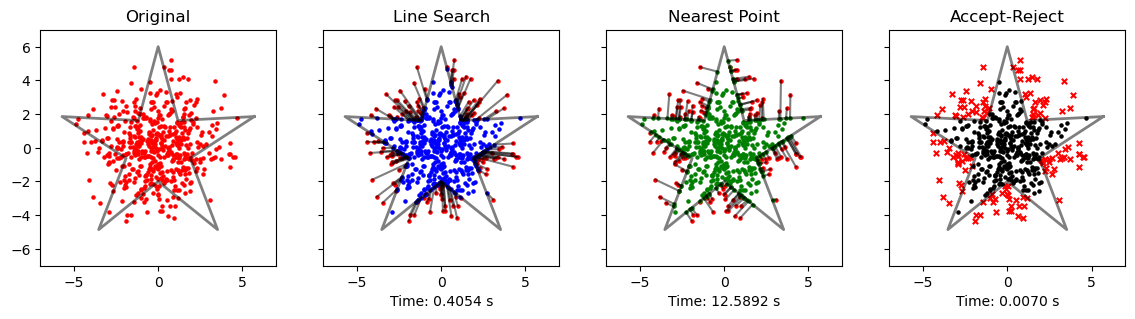

In [2]:
# Convert degrees to radians and define a set of angles in radians
angles = np.array([18, 54, 90, 126, 162, 198, 234, 270, 306, 342, 18]) * np.pi / 180

# Define a radius for each of the angles (alternates between 6 and 2, ending in 6)
radius = np.r_[np.tile([6, 2], 5), 6]

# Convert the polar coordinates (radius and angles) to Cartesian coordinates
x = radius * np.cos(angles)
y = radius * np.sin(angles)

# Combine x and y coordinates to form a polygon
polygon = np.c_[x, y]

c = lambda state: make_constraint(polygon)(np.array([state[0], state[1], 0, 0]))

# Define the mean and covariance matrix for the multivariate normal distribution
m = np.array([0, 0])
P = np.array([[3, 0], [0, 3]])

# Sample 500 particles from a 2D multivariate normal distribution
n = 500
particles = np.random.multivariate_normal(m, P, n)

# Apply line_search function to each particle and measure the computation time
start = time.time()
particles_line1 = np.zeros_like(particles)
for i, particle in enumerate(particles):
    particles_line1[i] = line_search(m, particle, c)
time_line1 = time.time() - start

# Apply nearest_point function to each particle and measure the computation time
start = time.time()
particles_nearest = np.zeros_like(particles)
for i, particle in enumerate(particles):
    particles_nearest[i] = nearest_point(*particle, c)
time_nearest = time.time() - start

# Apply c function (which seems to be a kind of filter or condition) to each particle and measure the computation time
start = time.time()
mask_ar = np.zeros(n, dtype=bool)
for i, particle in enumerate(particles):
    mask_ar[i] = c(particle)
particles_ar = particles[mask_ar]
time_ar = time.time() - start

# Create a 4-panel figure
fig, ax = plt.subplots(1, 4, figsize=(14, 9), sharey=True)
ax = ax.flatten()

# Plot the original polygon on each subplot
for i in range(len(ax)):
    ax[i].plot(polygon[:, 0], polygon[:, 1], color='k', linewidth=2, alpha=0.5)
    ax[i].set_xlim(-7, 7)
    ax[i].set_ylim(-7, 7)
    ax[i].set_aspect('equal')
    
# For subplots 1 and 2, add lines between original and transformed particles if they are different
for i in range(len(particles)):
    if not np.allclose(particles[i], particles_line1[i]):
        ax[1].plot([particles[i, 0], particles_line1[i, 0]], [particles[i, 1], particles_line1[i, 1]], color='k', alpha=0.5)
        ax[1].scatter(particles[i, 0], particles[i, 1], color='r', s=5)
        
for i in range(len(particles)):
    if not np.allclose(particles[i], particles_nearest[i]):
        ax[2].plot([particles[i, 0], particles_nearest[i, 0]], [particles[i, 1], particles_nearest[i, 1]], color='k', alpha=0.5)
        ax[2].scatter(particles[i, 0], particles[i, 1], color='r', s=5)
        
# On subplot 3, mark particles that did not satisfy the condition in the c function
ax[3].scatter(particles[~mask_ar, 0], particles[~mask_ar, 1], color='r', s=15, marker='x')

# Plot original and transformed particles on respective subplots
ax[0].scatter(particles[:, 0], particles[:, 1], color='r', s=5)
ax[1].scatter(particles_line1[:, 0], particles_line1[:, 1], color='b', s=5)
ax[2].scatter(particles_nearest[:, 0], particles_nearest[:, 1], color='g', s=5)
ax[3].scatter(particles_ar[:, 0], particles_ar[:, 1], color='k', s=5)

# Add titles and computation times to subplots
ax[0].set_title('Original')
ax[1].set_title('Line Search')
ax[1].set_xlabel('Time: {:.4f} s'.format(time_line1))
ax[2].set_title('Nearest Point')
ax[2].set_xlabel('Time: {:.4f} s'.format(time_nearest))
ax[3].set_title('Accept-Reject')
ax[3].set_xlabel('Time: {:.4f} s'.format(time_ar))

# Display the figure
plt.show()

## Trajectories

In [3]:
np.random.seed(131)
x_points, y_points, line_segments = track_example1()
trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath='output/track_1.pkl')
states, measurements = trajectory.get_data()
states = states[::2]
measurements = measurements[::2]
n = len(states)

In [4]:
model = StateSpaceModel()
Q, R, f, h = model.get_linear_model_function()

### Unconstrained

In [5]:
particle_filter = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_uncon, cov_estimates_smoothed_uncon = particle_filter.smoother(state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

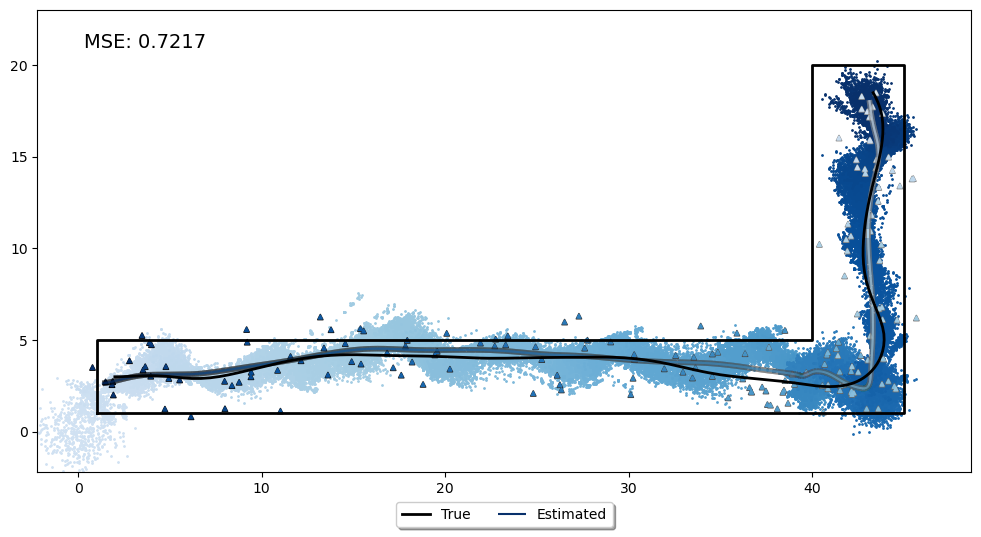

In [6]:
plot_particle_solution(states, state_estimates_smoothed_uncon, measurements, particle_history_uncon, line_segments)

### Constrained Accept-Reject

In [7]:
c = make_constraint(line_segments[0])
particle_filter = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='accept_reject', distribution='normal')
state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, resampled_history_con = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con, cov_estimates_smoothed_con = particle_filter.smoother(state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

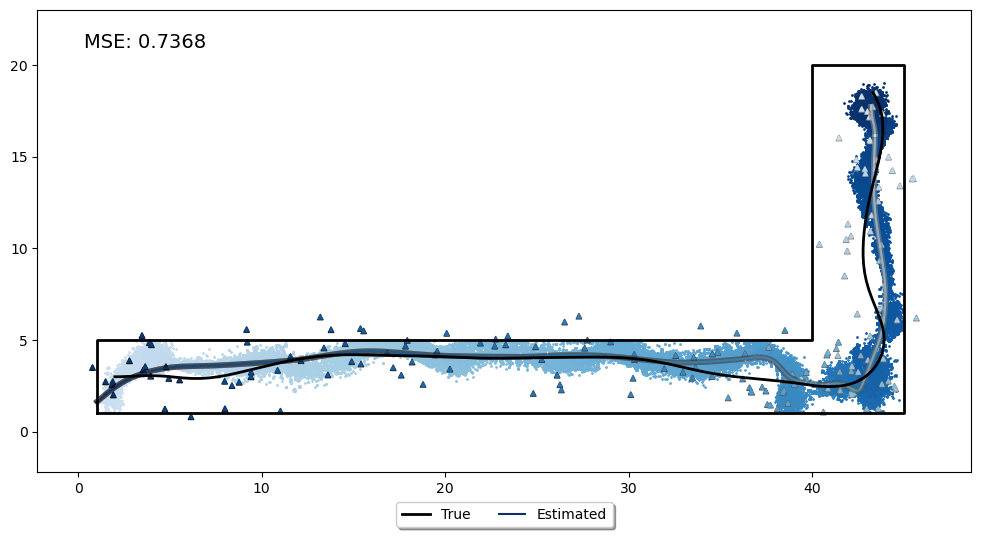

In [8]:
plot_particle_solution(states, state_estimates_smoothed_con, measurements, resampled_history_con, line_segments)

### Constrained Line Search

In [9]:
particle_filter_2 = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='line', distribution='normal')
state_estimates_con_2, cov_estimates_con_2, particle_history_con_2, weights_history_con_2, resampled_history_con_2 = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con_2, cov_estimates_smoothed_con_2 = particle_filter.smoother(state_estimates_con_2, cov_estimates_con_2, particle_history_con_2, weights_history_con_2, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

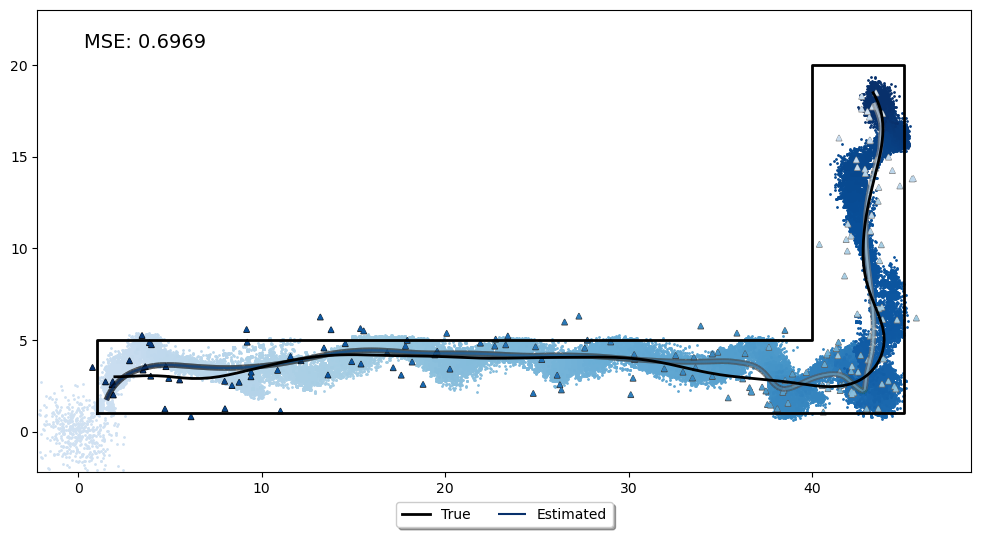

In [10]:
plot_particle_solution(states, state_estimates_smoothed_con_2, measurements, particle_history_con_2, line_segments)

### Constrained Line Search (also for average)

In [11]:
particle_filter_3 = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='line2', distribution='normal')
state_estimates_con_3, cov_estimates_con_3, particle_history_con_3, weights_history_con_3, resampled_history_con_3 = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con_3, cov_estimates_smoothed_con_3 = particle_filter.smoother(state_estimates_con_3, cov_estimates_con_3, particle_history_con_3, weights_history_con_3, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

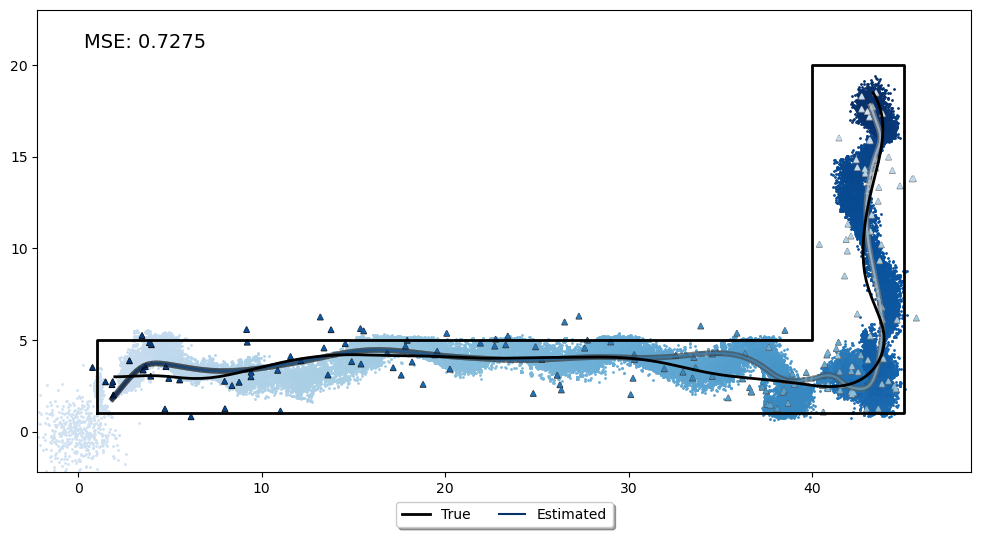

In [12]:
plot_particle_solution(states, state_estimates_smoothed_con_3, measurements, particle_history_con_3, line_segments)

### Constrained Line Search and Nearest

In [13]:
particle_filter_4 = PFC(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='nearest', distribution='normal')
state_estimates_con_4, cov_estimates_con_4, particle_history_con_4, weights_history_con_4, resampled_history_con_4 = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con_4, cov_estimates_smoothed_con_4 = particle_filter.smoother(state_estimates_con_4, cov_estimates_con_4, particle_history_con_4, weights_history_con_4, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

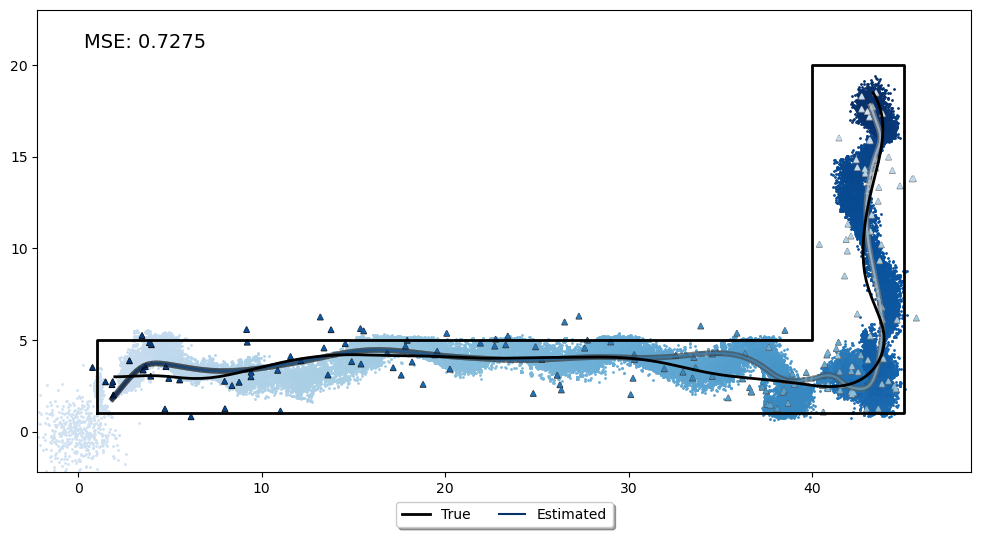

In [14]:
plot_particle_solution(states, state_estimates_smoothed_con_3, measurements, particle_history_con_3, line_segments)